In [1]:
import os
import sys
from pathlib import Path
sys.path.insert(1, os.path.realpath(os.path.pardir))

import torch
import torch.nn.functional as F
from torch import nn

import safetensors
from accelerate import notebook_launcher

from utils.data_utils import BrainDataset, get_tokenizer
from utils.train_utils import TrainConfig, run_train_model, count_parameters, load_model_weights, freeze_module

from dataclasses import dataclass
from simple_parsing.helpers import Serializable

from safetensors.torch import load_model
import albumentations as A

import matplotlib.pyplot as plt

In [2]:
from models.mirasol import Mirasol, MirasolConfig, Franky
from models.vq_brain_per_channel import SoundStream, VAEConfig


## Init brain module

In [3]:
vae_config = VAEConfig(C=256, levels=(8, 8, 6, 5))
vq_vae = SoundStream(**vae_config.to_dict())

model_config = MirasolConfig(window_size=512, w_latent_loss=1, w_recon_loss=0.1)
brain_model = Mirasol(model_config, vq_vae)


self.codebook_size 1920
self.downsample 8
Shape of the rope cache:  torch.Size([256, 16])
Shape of the causal model:  torch.Size([256, 256])
Full Mirasol model: number of parameters: 116.45M


## Init language model

In [4]:
from transformers import WhisperProcessor, WhisperForConditionalGeneration

# load model and processor
processor = WhisperProcessor.from_pretrained("openai/whisper-medium.en")
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-medium.en")
model.config.forced_decoder_ids = None


tokenizer = processor.tokenizer
whisper = {'decoder': model.model.decoder, 
           'proj_out': model.proj_out, 
           'tokenizer': tokenizer}

/opt/conda/envs/pytorch/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [5]:
import matplotlib.pyplot as plt

In [6]:
from einops import rearrange 
import torch 
x = torch.zeros(2, 128, 4, 64)

# x[0, :] = torch.arange(128).unsqueeze(-1)
x[0, 0, 0, :] = 100
x[0, 0, 1, :] = 101

x[0, 1, 0, :] = 200
x[0, 1, 1, :] = 201

x[1] += 3000

# x[1, 0, 0] = 1000
# x[1, 0, 1] = 1010


# print(x)

x_bt = rearrange(x, 'b t r d -> (b t) r d')
x_r = rearrange(x_bt, '(b t) r d -> b (t r) d', b=2)

In [7]:
print(x[0, :, 0, 0])

tensor([100., 200.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.])


In [8]:
print(x_r[0, ::4, 0])

tensor([100., 200.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.])


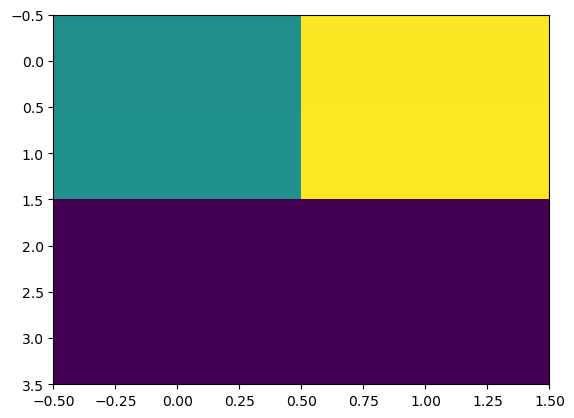

In [9]:
plt.imshow(x[0, :2, :, 0].T, aspect='auto')

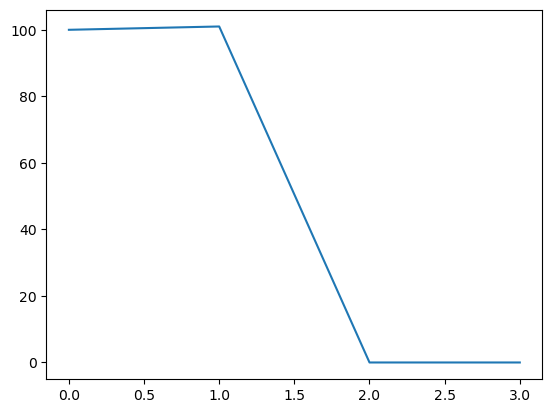

In [10]:
plt.plot(x_r[0, :4, 0])

## Init Franky

In [11]:
model = Franky(brain_model=brain_model, llm_model=whisper) 
model.train()

vq_weights = "/drive/logs/kovalev/vq_brain/medium_14M_256ws_8x_2000/step_78000_loss_0.0275.safetensors"
load_model_weights(model.brain_model.vq_model, vq_weights)

## let's freeeze 
# vqvae
freeze_module(model.brain_model.vq_model)

# # decoder
freeze_module(model.llm_decoder.embed_tokens)
freeze_module(model.llm_decoder.embed_positions)
freeze_module(model.proj_out)

count_parameters(model)

Full Franky: number of parameters: 573.64M
load compiled weights
Total: 573.64M, Trainable: 506.67M


(573639557, 506674560)

256
torch.Size([256, 256])


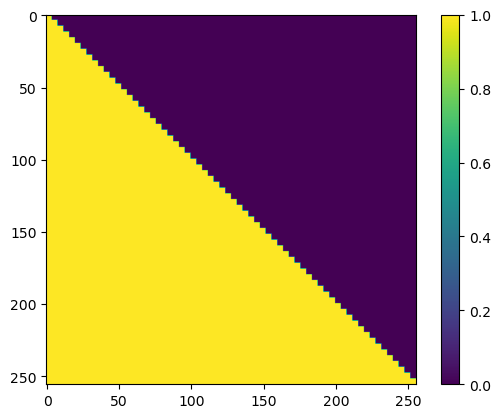

In [12]:
attn_mask = model.brain_model.causal.attn_mask
rope = model.brain_model.causal.rope_cache
print(model.brain_model.block_size)
print(attn_mask.shape)
plt.imshow(attn_mask)
plt.colorbar()

In [13]:
rope.shape

torch.Size([256, 16])

/opt/conda/envs/pytorch/lib/python3.10/site-packages/torch/_tensor.py:1064: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)


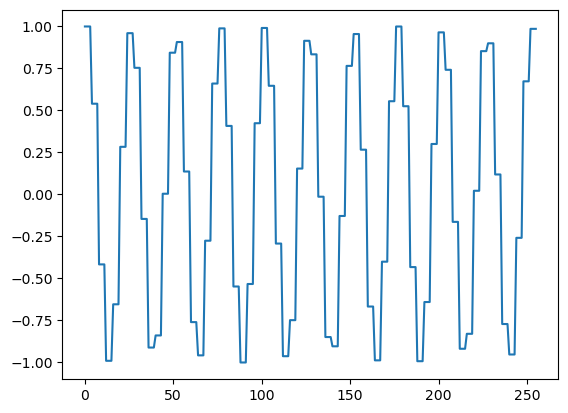

In [14]:
plt.plot(rope[:, 0])

In [15]:
window_size = model_config.window_size
n_electrodes = 256
max_tokens = 25

train_transform = A.Compose([
    
    # A.CoarseDropout(fill_value=0, p=0.5),
    # A.MultiplicativeNoise(multiplier=(0.9, 1.1), p=0.5),
    # A.GaussNoise(var_limit=0.005, mean=0, p=0.5),

    A.PadIfNeeded(min_height=window_size, min_width=n_electrodes, position='random', 
                  border_mode=0, value=0, always_apply=True),
    # A.RandomCrop(height=window_size, width=n_electrodes, always_apply=True),
    A.Crop(x_min=0, x_max=n_electrodes, y_min=0, y_max=window_size, always_apply=True),

])

test_transform = A.Compose([
    A.PadIfNeeded(min_height=window_size, min_width=n_electrodes, position='top_left', 
                  border_mode=0, value=0, always_apply=True),
    A.Crop(x_min=0, x_max=n_electrodes, y_min=0, y_max=window_size, always_apply=True)
])


data_path = Path("/drive/data/competitionData")

tokenize_function =  lambda text: tokenizer(text)['input_ids']

train_dataset = BrainDataset(data_path / 'train', tokenize_function=tokenize_function, transform=train_transform, max_tokens=max_tokens)
test_dataset = BrainDataset(data_path / 'test', tokenize_function=tokenize_function, transform=test_transform, max_tokens=max_tokens)

Runed processing of the  /drive/data/competitionData/train
len of the dataset: 8800
max signal size: 906 | max tokens size: 25
median signal size: 297.0 | median tokens size: 11.0
Runed processing of the  /drive/data/competitionData/test
len of the dataset: 880
max signal size: 919 | max tokens size: 22
median signal size: 283.5 | median tokens size: 10.0


In [16]:
# test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=False)

x, y, date = next(iter(train_dataloader))
loss, logits = model(x, y, date)

print(x.shape, y.shape, date)
# plt.imshow(x.detach()[0].T)
# plt.show()

torch.Size([1, 512, 256]) torch.Size([1, 25]) tensor([0])


# Work with data

In [ ]:
project_name = 'franky'
save_folder = Path("/drive/logs/kovalev")

train_config = TrainConfig(exp_name='mirasol-whisper-medium-full-fixed-v2',
                           mixed_precision=True,
                           batch_size=8, 
                           grad_accum=8,
                           num_workers=3,
                           pin_memory=True, 
                           eval_interval=2000, 
                           learning_rate=1e-4,
                           weight_decay=0.0, 
                           grad_clip=5,
                           lr_decay_iters=20_000, 
                           warmup_iters=1000, 
                           project_name=project_name, 
                           save_folder=save_folder
                          )
# indices = torch.arange(16)
# train_dataset = torch.utils.data.Subset(test_dataset, indices)
# test_dataset = torch.utils.data.Subset(test_dataset, indices)

args = (model, (train_dataset, test_dataset), train_config, model_config)
notebook_launcher(run_train_model, args, num_processes=1)

Launching training on one GPU.


/opt/conda/envs/pytorch/lib/python3.10/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(split_batches=True)
  warnings.warn(
wandb: Currently logged in as: koval_alvi. Use `wandb login --relogin` to force relogin


Device for training:  cuda
Num devices:  1
Completed initialization of scheduler
********************************************************************************************************************************************************************************************************************************

In [ ]:
x = test_dataset[0][0]
device = 'cpu'
x = torch.from_numpy(x[None, :]).to(device)
print(x.shape)
loss, y, binary = model(x, masking_ratio=0.75,  return_preds=True)

x = x.detach().cpu()[0]
y = y.detach().cpu()[0]
binary = binary.detach().cpu()[0]

import matplotlib.pyplot as plt 

# plt.plot(y[1, :])
# plt.show()
# plt.plot(x[1, :])
# plt.show()
loss = F.l1_loss(y, x, reduction='none')
print(torch.mean(loss[loss>0]))

plt.show()
plt.imshow(binary[:64].T, aspect='auto')
# plt.colorbar()
plt.show()
plt.imshow(torch.clip(y[:64].T, 0, 1), aspect='auto')
plt.colorbar()
plt.show()
plt.imshow(x[:64].T, aspect='auto' )
plt.colorbar()


In [ ]:
plt.show()
plt.plot(binary[:32, 10])
plt.show()
plt.plot(y[:32, 10])
# plt.show()
plt.plot(x[:32, 10])